In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip -q install seaborn==0.13.2

import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt

from textwrap import fill

In [ ]:
CSV_PATH = "/content/drive/MyDrive/Skin_project/original_skin_dataset_INFO.csv"

# Dataset distribution

In [ ]:
# --- Read CSV ---
df = pd.read_csv(CSV_PATH, sep=';')
print(df.columns)

Index(['patient_id', 'region', 'moisture_img', 'oiliness_img',
       'elasticity_img', 'texture_img', 'redness_img', 'hyperpigmentation_img',
       'moisture_score', 'texture_score', 'oiliness_score', 'redness_score',
       'hyperpigmentation_score', 'elasticity_score', 'gender', 'age',
       'skin_type', 'skin_ code'],
      dtype='object')


In [ ]:
# --- Setup ---
sns.set_theme(context="notebook", style="whitegrid",font_scale=0.85) #
plt.rcParams.update({
    "figure.dpi": 150,
    "axes.titleweight": "semibold",
    "axes.titlepad": 8,
    "axes.labelpad": 6,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "legend.frameon": False,
    "savefig.bbox": "tight",
})

FIG_DIR = "/content/figures"
os.makedirs(FIG_DIR, exist_ok=True)

# --- Minimal checks ---
df.columns = [c.strip().lower() for c in df.columns]
required = {"patient_id", "gender", "age"}
missing_req = required - set(df.columns)
if missing_req:
    raise ValueError(f"Missing required columns: {missing_req}")

demo = df.drop_duplicates(subset="patient_id", keep="first").copy()

# --- Missingness report ---
miss = {
    "patients (unique)": int(demo["patient_id"].nunique()),
    "age (missing %)": round(pd.to_numeric(demo["age"], errors="coerce").isna().mean()*100, 2),
    "gender (missing %)": round(demo["gender"].isna().mean()*100, 2),
}
if "skin_type" in demo.columns:
    miss["skin_type (missing %)"] = round(demo["skin_type"].isna().mean()*100, 2)
if "skin_code" in demo.columns:
    miss["skin_code (missing %)"] = round(pd.to_numeric(demo["skin_code"], errors="coerce").isna().mean()*100, 2)

print("=== Cohort Summary (compact) ===")
for k, v in miss.items():
    print(f"{k}: {v}")

# --- Helpers ---
def annotate_counts_perc(ax, counts, total, dy=4, fs=9):
    for p, val in zip(ax.patches, counts.values):
        if np.isnan(val): continue
        pct = (val/total*100) if total > 0 else 0
        ax.annotate(f"{int(val)}\n{pct:.1f}%",
                    (p.get_x() + p.get_width()/2, p.get_height()),
                    ha="center", va="bottom",
                    xytext=(0, dy), textcoords="offset points",
                    fontsize=fs)

def pastel_palette(n):
    return sns.color_palette("pastel", n)

=== Cohort Summary (compact) ===
patients (unique): 39
age (missing %): 0.0
gender (missing %): 0.0
skin_type (missing %): 0.0


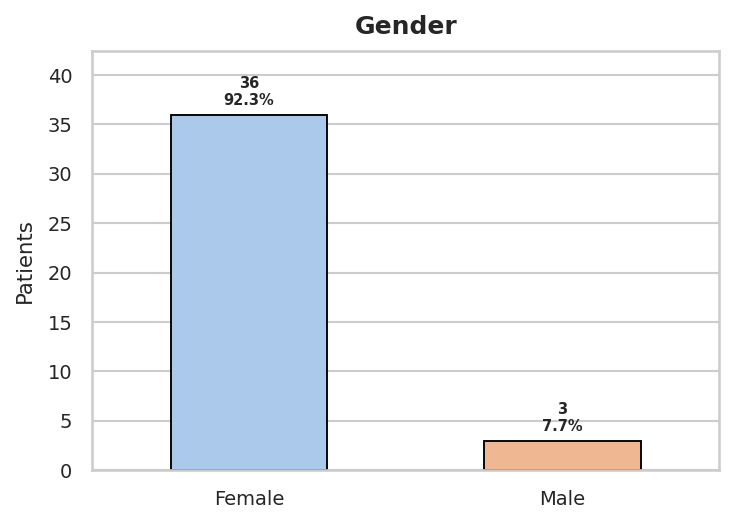

In [ ]:
# --- Gender distribution ---

gender_order = ["Female", "Male"]
g_series = demo["gender"].astype(str).str.capitalize()
g_series = pd.Categorical(g_series, categories=gender_order, ordered=True)
g_counts = pd.Series(g_series).value_counts().sort_index()
total_g = int(g_counts.sum())

fig, ax = plt.subplots(figsize=(5, 3.6))

plot_df = pd.DataFrame({"gender": g_counts.index, "count": g_counts.values})
sns.barplot(
    data=plot_df, x="gender", y="count", hue="gender",
    palette=pastel_palette(len(g_counts)),
    edgecolor="black", linewidth=0.9,
    width=0.5,
    dodge=False, legend=False, ax=ax
)

ax.set_ylim(0, max(g_counts.values) * 1.18)

for p, val in zip(ax.patches, g_counts.values):
    pct = (val / total_g * 100) if total_g else 0
    ax.annotate(
        f"{int(val)}\n{pct:.1f}%",
        (p.get_x() + p.get_width()/2, p.get_height()),
        ha="center", va="bottom",
        xytext=(0, 3), textcoords="offset points",
        fontsize=7, fontweight="bold"
    )

ax.set_xlabel("")
ax.set_ylabel("Patients")
ax.set_title("Gender", fontsize=12)
plt.tight_layout()
plt.savefig(f"{FIG_DIR}/gender_distribution_small_slim.png", dpi=160)
plt.show()


In [ ]:
schemes = {
    "pastel_blue":   ["#A7C7E7", "#6A9ACB"],
    "pastel_green":  ["#BFE3B4", "#7EB47A"],
    "pastel_orange": ["#FFD3A4", "#E8A66A"],
    "pastel_pink":   ["#F7C1D9", "#E08AB1"],
}

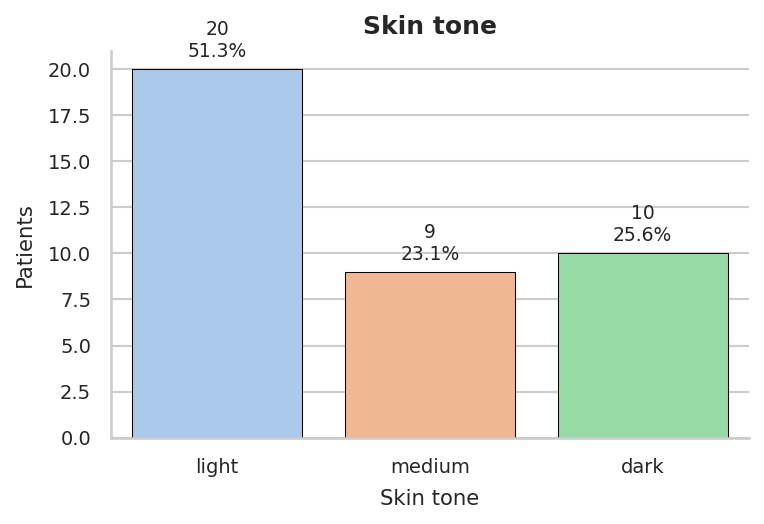

In [ ]:
# ===========================================
# 3) Skin tone (3 classes) distribution
# ===========================================
has_skin_type = "skin_type" in demo.columns
has_skin_code = "skin_code" in demo.columns
if has_skin_type or has_skin_code:
    if has_skin_type:
        skin = demo["skin_type"].astype(str).str.lower()
    else:
        code_map = {1: "light", 2: "medium", 3: "dark"}
        skin = pd.to_numeric(demo["skin_code"], errors="coerce").map(code_map)

    skin_order = ["light", "medium", "dark"]
    skin = pd.Categorical(skin, categories=skin_order, ordered=True)
    s_counts = pd.Series(skin).value_counts().sort_index()
    total_s = int(s_counts.sum())

    fig, ax = plt.subplots(figsize=(5.2, 3.6))
    s_df = pd.DataFrame({"skin": s_counts.index, "count": s_counts.values})
    sns.barplot(data=s_df, x="skin", y="count", hue="skin",
                palette=pastel_palette(len(s_counts)), edgecolor="black", linewidth=0.5,
                dodge=False, legend=False, ax=ax)
    ax.set_xlabel("Skin tone")
    ax.set_ylabel("Patients")
    ax.set_title(f"Skin tone", fontsize=12)
    annotate_counts_perc(ax, s_counts, total_s)
    plt.tight_layout()
    plt.savefig(f"{FIG_DIR}/skin_tone_distribution_small.png")
    plt.show()

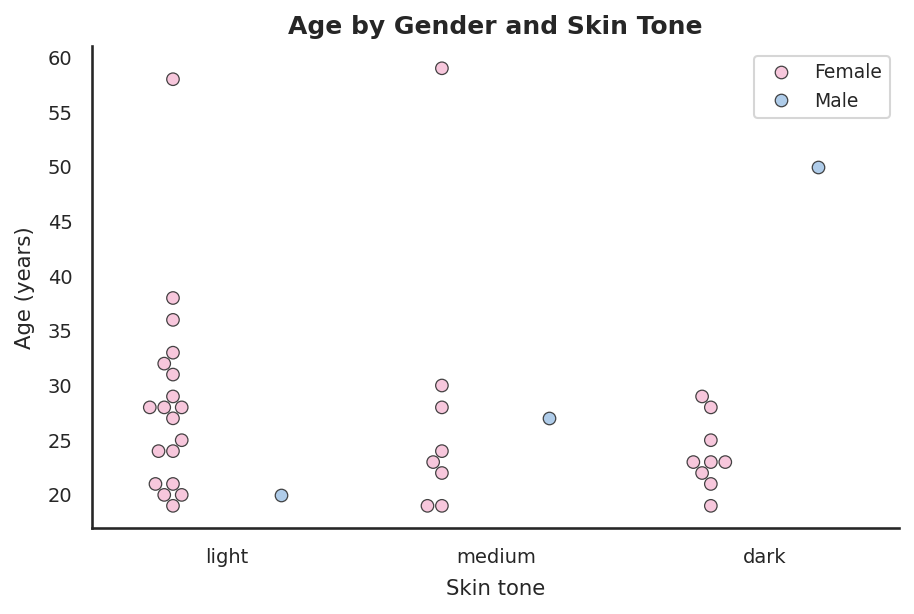

In [ ]:
# ---  Age by Gender across Skin Types ---

sns.set_style("white")

if "demo" not in globals():
    df.columns = [c.strip().lower() for c in df.columns]
    demo = df.drop_duplicates(subset="patient_id", keep="first").copy()

if "skin_type" in demo.columns:
    skin = demo["skin_type"].astype(str).str.lower()
else:
    code_map = {1: "light", 2: "medium", 3: "dark"}
    skin = pd.to_numeric(demo["skin_code"], errors="coerce").map(code_map)

tmp = pd.DataFrame({
    "age": pd.to_numeric(demo["age"], errors="coerce"),
    "gender": demo["gender"].astype(str).str.capitalize(),
    "skin": skin
}).dropna()

skin_order = ["light", "medium", "dark"]
gender_order = ["Female", "Male"]
palette = {"Female": "#F7C1D9", "Male": "#A7C7E7"}

tmp["skin"] = pd.Categorical(tmp["skin"], categories=skin_order, ordered=True)
tmp["gender"] = pd.Categorical(tmp["gender"], categories=gender_order, ordered=True)

fig, ax = plt.subplots(figsize=(6.2, 4.2))


sns.swarmplot(
    data=tmp, x="skin", y="age", hue="gender",
    order=skin_order, hue_order=gender_order,
    dodge=True, size=6, marker="o", alpha=0.9,
    edgecolor="#2F2F2F", linewidth=0.6,
    palette=palette, ax=ax, zorder=2
)


# Merge duplicate legends (swarm + boxplot)
handles, labels = ax.get_legend_handles_labels()
# Keep the first two (Female/Male) and discard duplicates
ax.legend(handles[:2], labels[:2], title="", loc="upper right", frameon=True, fontsize=9)

ax.set_xlabel("Skin tone")
ax.set_ylabel("Age (years)")
ax.set_title("Age by Gender and Skin Tone", fontsize=12, pad=6)
sns.despine(ax=ax)

plt.tight_layout()
plt.savefig(f"{FIG_DIR}/age_gender_by_skin_clear.png", dpi=160)
plt.show()


In [ ]:

mpl.rcParams["font.family"] = "DejaVu Sans"
sns.set_theme(context="notebook", style="whitegrid", font_scale=0.95)


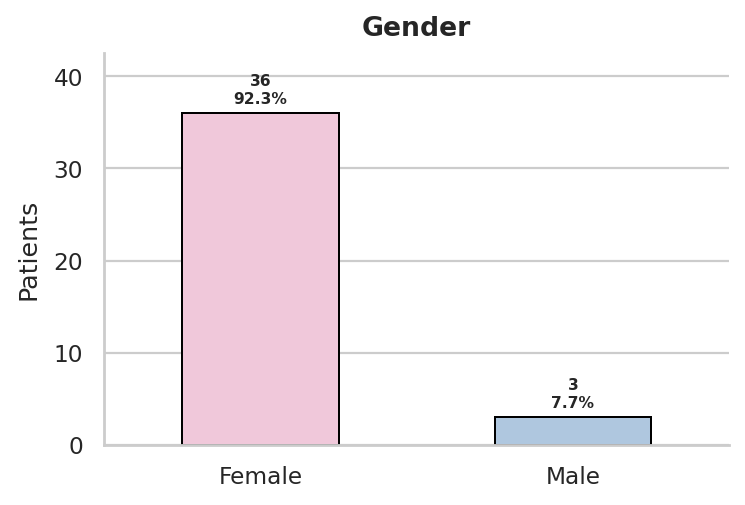

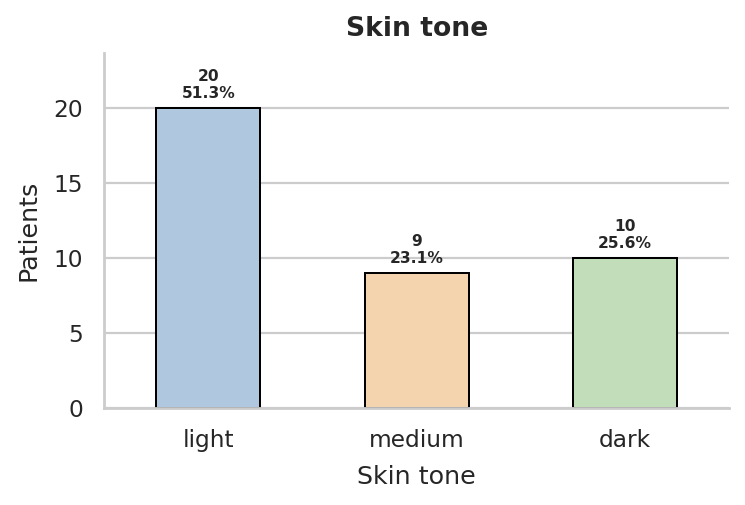

In [ ]:
# ===== Harmonized small bar charts (Gender & Skin tone) =====

# --- Compact theme + nicer font ---
sns.set_theme(context="notebook", style="whitegrid", font_scale=0.95)


plt.rcParams.update({
    "figure.dpi": 160,
    "axes.titleweight": "semibold",
    "axes.titlepad": 8,
    "axes.labelpad": 6,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "legend.frameon": False,
    "savefig.bbox": "tight",
})

# Helpers
def annotate_counts_perc(ax, counts, total, dy=3, fs=7):
    """Write small bold count + percent above each bar."""
    for p, val in zip(ax.patches, counts.values):
        if np.isnan(val):
            continue
        pct = (val/total*100) if total else 0
        ax.annotate(
            f"{int(val)}\n{pct:.1f}%",
            (p.get_x() + p.get_width()/2, p.get_height()),
            ha="center", va="bottom",
            xytext=(0, dy), textcoords="offset points",
            fontsize=fs, fontweight="bold"
        )

BAR_WIDTH   = 0.50                 # same bar thickness for both charts
FIGSIZE     = (4.8, 3.3)           # slightly narrower overall frame
EDGE_COLOR  = "black"
EDGE_LW     = 0.9
TITLE_FS    = 12

# =========================
# Gender distribution
# =========================
gender_order = ["Female", "Male"]
g_series = pd.Categorical(demo["gender"].astype(str).str.capitalize(),
                          categories=gender_order, ordered=True)
g_counts = pd.Series(g_series).value_counts().sort_index()
total_g = int(g_counts.sum())

# fixed pastel colors (Female=pink, Male=blue)
gender_palette = {"Female": "#F7C1D9", "Male": "#A7C7E7"}

fig, ax = plt.subplots(figsize=FIGSIZE)
plot_df = pd.DataFrame({"gender": g_counts.index, "count": g_counts.values})

sns.barplot(
    data=plot_df, x="gender", y="count", hue="gender",
    palette=gender_palette, edgecolor=EDGE_COLOR, linewidth=EDGE_LW,
    width=BAR_WIDTH, dodge=False, legend=False, ax=ax
)

# Slightly more headroom moves the 40-line up
ymax = max(g_counts.values)
ax.set_ylim(0, ymax * 1.70)

label_offsets_pt = {"Female": -6, "Male": 3}  # negative = nudge down, positive = up

ax.set_ylim(0, max(g_counts.values)*1.18)   # headroom for labels
ax.set_xlabel("")
ax.set_ylabel("Patients")
ax.set_title("Gender", fontsize=TITLE_FS)

annotate_counts_perc(ax, g_counts, total_g)
plt.tight_layout()
plt.savefig(f"{FIG_DIR}/gender_distribution_harmonized.png", dpi=160)
plt.show()

# =========================
# Skin tone distribution (3 classes)
# =========================
has_skin_type = "skin_type" in demo.columns
has_skin_code = "skin_code" in demo.columns

if has_skin_type or has_skin_code:
    if has_skin_type:
        skin = demo["skin_type"].astype(str).str.lower()
    else:
        code_map = {1: "light", 2: "medium", 3: "dark"}
        skin = pd.to_numeric(demo["skin_code"], errors="coerce").map(code_map)

    skin_order = ["light", "medium", "dark"]
    skin = pd.Categorical(skin, categories=skin_order, ordered=True)
    s_counts = pd.Series(skin).value_counts().sort_index()
    total_s = int(s_counts.sum())

    # pastel, stable mapping for tones
    skin_palette = {"light": "#A7C7E7", "medium": "#FFD3A4", "dark": "#BFE3B4"}

    fig, ax = plt.subplots(figsize=FIGSIZE)
    s_df = pd.DataFrame({"skin": s_counts.index, "count": s_counts.values})

    sns.barplot(
        data=s_df, x="skin", y="count", hue="skin",
        palette=skin_palette, edgecolor=EDGE_COLOR, linewidth=EDGE_LW,
        width=BAR_WIDTH, dodge=False, legend=False, ax=ax
    )

    ax.set_ylim(0, max(s_counts.values)*1.18)   # same headroom rule
    ax.set_xlabel("Skin tone")
    ax.set_ylabel("Patients")
    ax.set_title("Skin tone", fontsize=TITLE_FS)

    annotate_counts_perc(ax, s_counts, total_s)
    plt.tight_layout()
    plt.savefig(f"{FIG_DIR}/skin_tone_distribution_harmonized.png", dpi=160)
    plt.show()

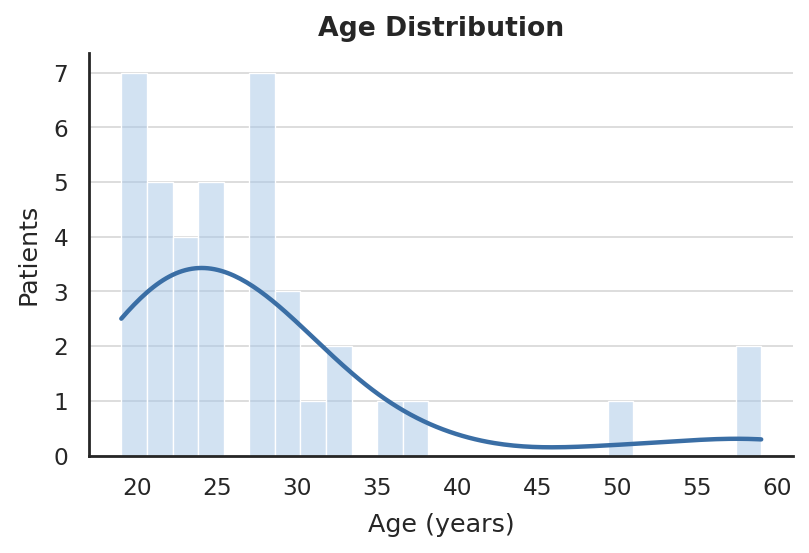

In [ ]:
# --- Age distribution ---

# choose one: "pastel_blue", "pastel_green", "pastel_orange", "pastel_pink"
scheme_name = "pastel_blue"

schemes = {
    "pastel_blue":   {"bar": "#A7C7E7", "edge": "#FFFFFF", "line": "#3A6EA5"},
    "pastel_green":  {"bar": "#BFE3B4", "edge": "#FFFFFF", "line": "#4E8850"},
    "pastel_orange": {"bar": "#FFD3A4", "edge": "#FFFFFF", "line": "#C9792B"},
    "pastel_pink":   {"bar": "#F7C1D9", "edge": "#FFFFFF", "line": "#C55C8A"},
}
c = schemes[scheme_name]

age = pd.to_numeric(demo["age"], errors="coerce").dropna()
fig, ax = plt.subplots(figsize=(5.2, 3.6))

sns.histplot(
    age,
    kde=True,
    bins=25,
    ax=ax,
    color=c["bar"],
    edgecolor=c["edge"],
    linewidth=0.6
)

# KDE line
if ax.lines:
    ax.lines[0].set_color(c["line"])
    ax.lines[0].set_linewidth(2.0)
    ax.lines[0].set_zorder(3)


ax.set_axisbelow(True)
ax.grid(False)
ax.yaxis.grid(True, which="major", linestyle="-",
              linewidth=0.8, color="#D0D0D0", alpha=0.8)


sns.despine(ax=ax, top=True, right=True)

ax.set_xlabel("Age (years)")
ax.set_ylabel("Patients")
ax.set_title("Age Distribution", fontsize=12)
plt.tight_layout()
plt.savefig(f"{FIG_DIR}/age_distribution_small_{scheme_name}.png", dpi=160)
plt.show()


In [ ]:
#########################################################################################################

Total images: 77


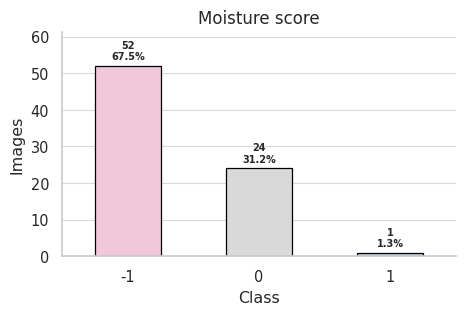

Saved: /content/drive/MyDrive/Skin_project/report images/moisture_score_class_distribution.png


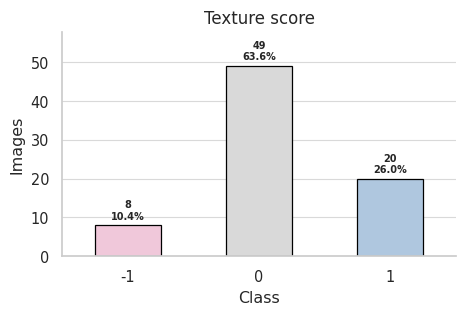

Saved: /content/drive/MyDrive/Skin_project/report images/texture_score_class_distribution.png


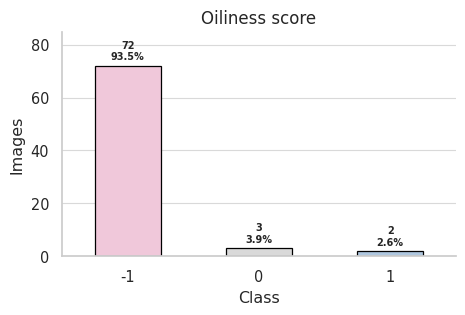

Saved: /content/drive/MyDrive/Skin_project/report images/oiliness_score_class_distribution.png


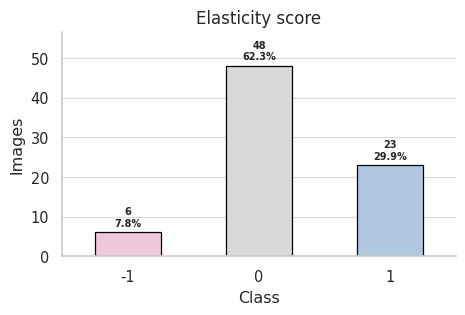

Saved: /content/drive/MyDrive/Skin_project/report images/elasticity_score_class_distribution.png


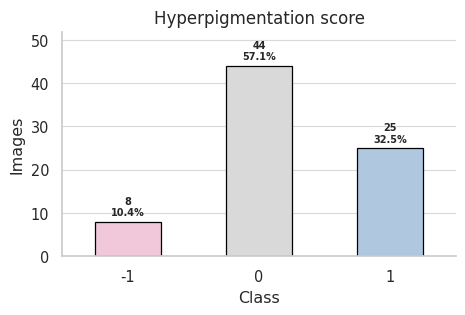

Saved: /content/drive/MyDrive/Skin_project/report images/hyperpigmentation_score_class_distribution.png


In [ ]:
# ===== Class distributions for 5 features (counts of -1, 0, 1) =====
# rows = images. We ignore redness_score.

# Style to match your other figures
mpl.rcParams["font.family"] = "DejaVu Sans"
sns.set_theme(context="notebook", style="whitegrid", font_scale=0.95)

FIG_DIR = "/content/drive/MyDrive/Skin_project/report images"
os.makedirs(FIG_DIR, exist_ok=True)

features = [
    "moisture_score",
    "texture_score",
    "oiliness_score",
    "elasticity_score",
    "hyperpigmentation_score",
]

# Colors per class: -1, 0, 1
class_order = [-1, 0, 1]
class_palette = {
    -1: "#F7C1D9",  # pastel pink
    0:  "#D9D9D9",  # light gray
    1:  "#A7C7E7",  # pastel blue
}

def annotate_counts_perc(ax, counts, total, dy=3, fs=7):
    for p, val in zip(ax.patches, counts.values):
        pct = (val / total * 100) if total else 0
        ax.annotate(
            f"{int(val)}\n{pct:.1f}%",
            (p.get_x() + p.get_width()/2, p.get_height()),
            ha="center", va="bottom",
            xytext=(0, dy), textcoords="offset points",
            fontsize=fs, fontweight="bold"
        )

print(f"Total images: {len(df)}")

for col in features:
    if col not in df.columns:
        print(f"[skip] Column not found: {col}")
        continue

    # Count only valid classes -1, 0, 1 (ignore NaN / other values if any)
    series = pd.to_numeric(df[col], errors="coerce")
    counts = series.value_counts().reindex(class_order, fill_value=0).astype(int)
    total_nonmissing = int(series.isin(class_order).sum())

    # Prepare plotting frame
    plot_df = pd.DataFrame({
        "cls": class_order,
        "count": [counts[c] for c in class_order],
    })
    plot_df["cls_str"] = plot_df["cls"].astype(str)
    colors = [class_palette[c] for c in plot_df["cls"]]

    # Draw bar chart (harmonized sizing and style)
    fig, ax = plt.subplots(figsize=(4.8, 3.3))
    sns.barplot(
        data=plot_df, x="cls_str", y="count", hue="cls_str",
        palette=colors, edgecolor="black", linewidth=0.9,
        width=0.50, dodge=False, legend=False, ax=ax
    )

    # Horizontal grid only (no verticals)
    ax.set_axisbelow(True)
    ax.grid(False)
    ax.yaxis.grid(True, which="major", linestyle="-", linewidth=0.8, color="#D0D0D0", alpha=0.8)
    sns.despine(ax=ax, top=True, right=True)

    # Headroom for labels + annotations
    ax.set_ylim(0, max(plot_df["count"].max(), 1) * 1.18)
    annotate_counts_perc(ax, counts, total_nonmissing)

    # Labels & title
    ax.set_xlabel("Class")
    ax.set_ylabel("Images")
    # Nicely formatted title from column name
    nice_title = col.replace("_", " ").replace("score", "Score").title().replace("Score", "score")
    ax.set_title(f"{nice_title}", fontsize=12)

    plt.tight_layout()
    outpath = f"{FIG_DIR}/{col}_class_distribution.png"
    plt.savefig(outpath, dpi=160)
    plt.show()
    print(f"Saved: {outpath}")


Total images across features (excluding redness_score): 385
  moisture_score: 77 images
  texture_score: 77 images
  oiliness_score: 77 images
  elasticity_score: 77 images
  hyperpigmentation_score: 77 images


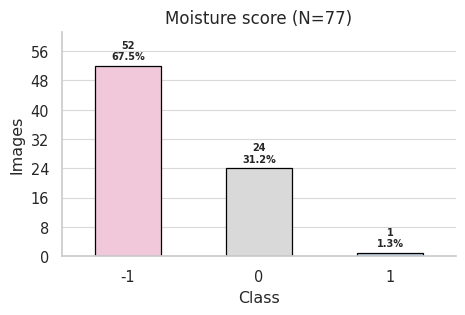

Saved: /content/figures/moisture_score_class_distribution.png


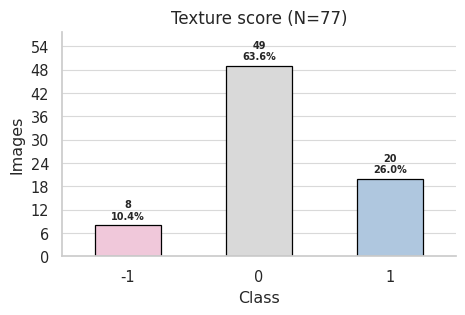

Saved: /content/figures/texture_score_class_distribution.png


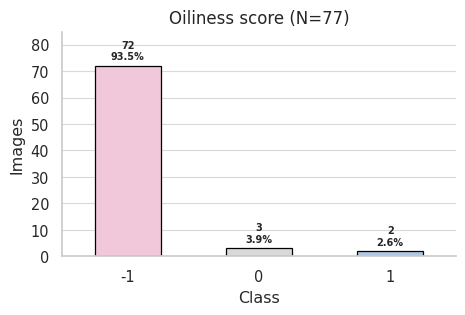

Saved: /content/figures/oiliness_score_class_distribution.png


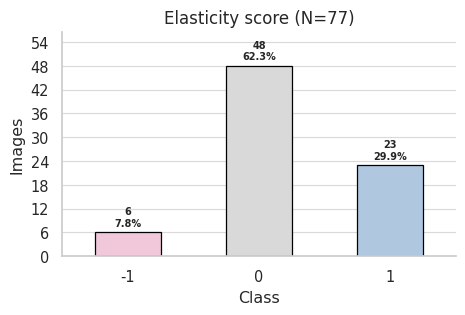

Saved: /content/figures/elasticity_score_class_distribution.png


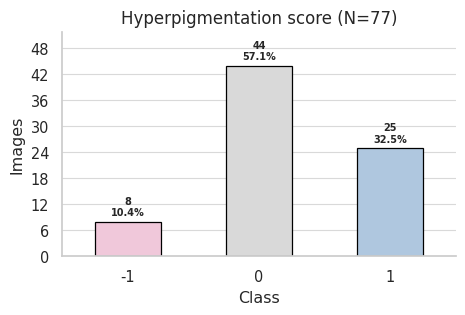

Saved: /content/figures/hyperpigmentation_score_class_distribution.png


In [ ]:
# ===== Class distributions by image (5 features: counts of -1, 0, 1) =====
# Rows = patients; each row has one image per feature -> image count = valid entries per feature

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import MaxNLocator
import os

# Style: same as your harmonized charts
mpl.rcParams["font.family"] = "DejaVu Sans"
sns.set_theme(context="notebook", style="whitegrid", font_scale=0.95)

FIG_DIR = "/content/drive/MyDrive/Skin_project/report images"
os.makedirs(FIG_DIR, exist_ok=True)

features = [
    "moisture_score",
    "texture_score",
    "oiliness_score",
    "elasticity_score",
    "hyperpigmentation_score",
]

class_order = [-1, 0, 1]
class_palette = {-1: "#F7C1D9", 0: "#D9D9D9", 1: "#A7C7E7"}  # pastel pink/gray/blue

BAR_WIDTH = 0.50
EDGE_LW   = 0.9

def annotate_counts_perc(ax, counts, total, dy=3, fs=7):
    for p, val in zip(ax.patches, counts.values):
        pct = (val / total * 100) if total else 0
        ax.annotate(
            f"{int(val)}\n{pct:.1f}%",
            (p.get_x() + p.get_width()/2, p.get_height()),
            ha="center", va="bottom",
            xytext=(0, dy), textcoords="offset points",
            fontsize=fs, fontweight="bold"
        )

# --- Compute overall total images across the five features (valid class entries only)
total_images_all = 0
valid_per_feature = {}

for col in features:
    if col not in df.columns:
        valid_per_feature[col] = 0
        continue
    s = pd.to_numeric(df[col], errors="coerce")
    valid = int(s.isin(class_order).sum())
    valid_per_feature[col] = valid
    total_images_all += valid

print(f"Total images across features (excluding redness_score): {total_images_all}")
for k, v in valid_per_feature.items():
    print(f"  {k}: {v} images")

# --- Plot each feature
for col in features:
    if col not in df.columns:
        print(f"[skip] Column not found: {col}")
        continue

    s = pd.to_numeric(df[col], errors="coerce")
    # counts for classes (images) and total valid images for this feature
    counts = s.value_counts().reindex(class_order, fill_value=0).astype(int)
    N_feat = int(s.isin(class_order).sum())

    plot_df = pd.DataFrame({
        "cls": class_order,
        "count": [counts[c] for c in class_order],
        "cls_str": [str(c) for c in class_order],
    })
    colors = [class_palette[c] for c in class_order]

    fig, ax = plt.subplots(figsize=(4.8, 3.3))
    sns.barplot(
        data=plot_df, x="cls_str", y="count", hue="cls_str",
        palette=colors, edgecolor="black", linewidth=EDGE_LW,
        width=BAR_WIDTH, dodge=False, legend=False, ax=ax
    )

    # Horizontal line grid only
    ax.set_axisbelow(True)
    ax.grid(False)
    ax.yaxis.grid(True, which="major", linestyle="-", linewidth=0.8, color="#D0D0D0", alpha=0.8)
    sns.despine(ax=ax, top=True, right=True)

    ax.set_ylim(0, max(plot_df["count"].max(), 1) * 1.18)
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    annotate_counts_perc(ax, counts, N_feat)

    ax.set_xlabel("Class")
    ax.set_ylabel("Images")
    nice = col.replace("_", " ").replace("score", "Score").title().replace("Score", "score")
    ax.set_title(f"{nice} (N={N_feat})", fontsize=12)

    plt.tight_layout()
    outpath = f"{FIG_DIR}/{col}_class_distribution.png"
    plt.savefig(outpath, dpi=160)
    plt.show()
    print(f"Saved: {outpath}")


# SAMPLES OF GENERATED IMAGES VERSUS REAL

In [ ]:

# ====== CONFIG ======
LOG_CSV   = "/content/drive/MyDrive/Skin_project/diffusion_oversample_70_2/oversample_log_2.csv"
SAVE_DIR  = "/content/drive/MyDrive/Skin_project/sample_pairs_per_feature"
MAKE_MONTAGE_TOO = Tru
MONTAGE_FILENAME_FMT = "{feature}__pair.png"

# ====== Load log ======
assert os.path.exists(LOG_CSV), f"Log not found: {LOG_CSV}"
log = pd.read_csv(LOG_CSV)

# ensure needed cols exist
required = {"feature", "keep", "real_path", "synthetic_path"}
missing = required - set(log.columns)
assert not missing, f"Missing required columns in log: {missing}"

# normalise 'keep' to bool
if log["keep"].dtype != bool:
    log["keep"] = log["keep"].astype(str).str.lower().isin(["true","1","yes","y"])

# keep only rows with valid file paths AND kept==True
def _exists(p): return isinstance(p, str) and os.path.exists(p)
log = log[log["keep"] & log["real_path"].apply(_exists) & log["synthetic_path"].apply(_exists)].reset_index(drop=True)
if log.empty:
    raise SystemExit("No valid (kept) rows with existing files found.")

# ====== Make output dir ======
os.makedirs(SAVE_DIR, exist_ok=True)

# ====== Helper (optional montage) ======
def save_montage(real_img_path, synth_img_path, out_path):
    r = Image.open(real_img_path).convert("RGB")
    s = Image.open(synth_img_path).convert("RGB")
    # match heights, simple letterbox to max height
    h = max(r.height, s.height)
    def _fit_h(im):
        scale = h / im.height
        return im.resize((int(im.width * scale), h))
    r2, s2 = _fit_h(r), _fit_h(s)
    canvas = Image.new("RGB", (r2.width + s2.width, h), (255, 255, 255))
    canvas.paste(r2, (0, 0)); canvas.paste(s2, (r2.width, 0))
    canvas.save(out_path)

# ====== One random kept example per feature ======
features = sorted(log["feature"].dropna().unique().tolist())
print(f"Found features: {features}")

saved = []
for feat in features:
    sub = log[log["feature"] == feat]
    if sub.empty:
        print(f"[{feat}] no kept examples with existing files — skipping.")
        continue

    # random row (new pick each run; no fixed seed)
    row = sub.sample(1).iloc[0]
    real_path  = row["real_path"]
    synth_path = row["synthetic_path"]

    # choose extensions based on originals
    real_ext  = os.path.splitext(real_path)[1].lower() or ".png"
    synth_ext = os.path.splitext(synth_path)[1].lower() or ".png"

    # file names
    out_real  = os.path.join(SAVE_DIR, f"{feat}__real{real_ext}")
    out_synth = os.path.join(SAVE_DIR, f"{feat}__synthetic{synt_ext}")

    # save copies (preserve original pixels)
    Image.open(real_path).save(out_real)
    Image.open(synth_path).save(out_synth)

    if MAKE_MONTAGE_TOO:
        out_pair = os.path.join(SAVE_DIR, MONTAGE_FILENAME_FMT.format(feature=feat))
        save_montage(real_path, synth_path, out_pair)

    saved.append((feat, out_real, out_synth))
    print(f"[{feat}] saved:\n  - {out_real}\n  - {out_synth}")

print(f"\n Saved {len(saved)} feature pairs to: {SAVE_DIR}")


# RESULTS

Saved figure to: /content/drive/MyDrive/Skin_project/report_images/macroF1_models_side_by_side.png


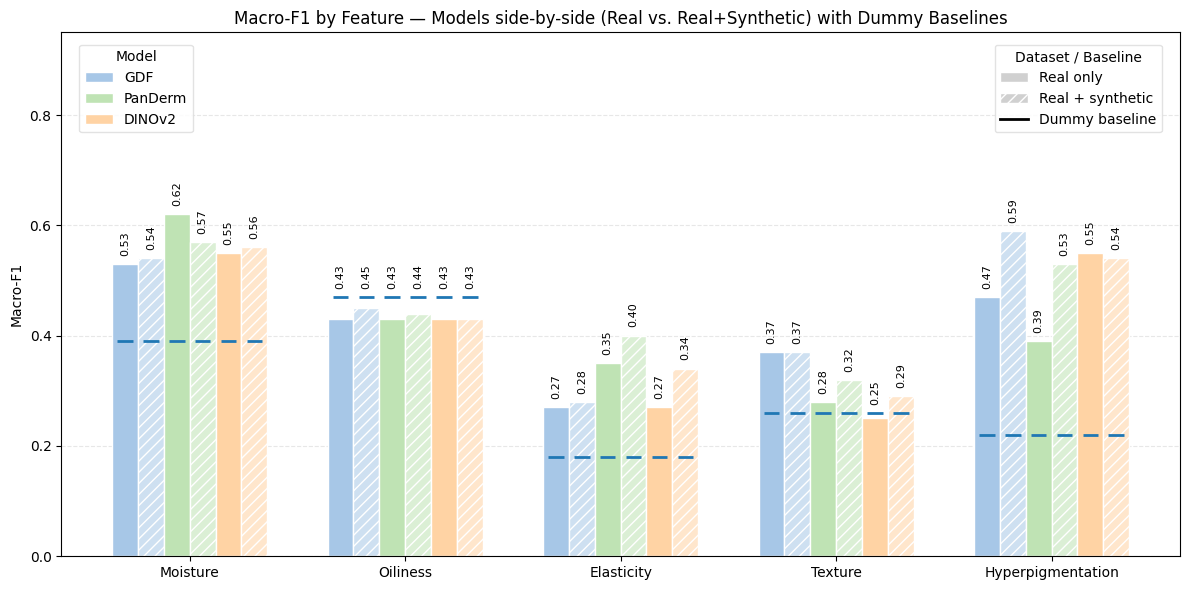

In [ ]:

# ===== Pastel palette per MODEL =====
model_colors = {
    "GDF":    "#A7C7E7",  # pastel blue
    "PanDerm":"#BFE3B4",  # pastel green
    "DINOv2": "#FFD3A4",  # pastel orange
}
EDGE_COLOR = "#FFFFFF"

def lighten(hex_color, factor=0.55):
    hex_color = hex_color.lstrip("#")
    r, g, b = [int(hex_color[i:i+2], 16) for i in (0, 2, 4)]
    r = int(r + (255 - r) * (1 - factor))
    g = int(g + (255 - g) * (1 - factor))
    b = int(b + (255 - b) * (1 - factor))
    return f"#{r:02X}{g:02X}{b:02X}"

# ===== Data (means) =====
features = ["Moisture", "Oiliness", "Elasticity", "Texture", "Hyperpigmentation"]
models   = ["GDF", "PanDerm", "DINOv2"]
macro_f1 = {
    "GDF":     {"real":  [0.53, 0.43, 0.27, 0.37, 0.47],
                "synth": [0.54, 0.45, 0.28, 0.37, 0.59]},
    "PanDerm": {"real":  [0.62, 0.43, 0.35, 0.28, 0.39],
                "synth": [0.57, 0.44, 0.40, 0.32, 0.53]},
    "DINOv2":  {"real":  [0.55, 0.43, 0.27, 0.25, 0.55],
                "synth": [0.56, 0.43, 0.34, 0.29, 0.54]},
}

# ===== Dummy baselines (Macro-F1) per feature =====
dummy_macro_f1 = {
    "Moisture": 0.39,
    "Oiliness": 0.47,
    "Elasticity": 0.18,
    "Texture": 0.26,
    "Hyperpigmentation": 0.22,
}

# ===== Plot config =====
x = np.arange(len(features))
bar_w = 0.12
gap   = bar_w * 2.0
model_offsets = np.array([-1, 0, 1]) * gap

fig, ax = plt.subplots(figsize=(12, 6))

PAD_ABOVE = 0.015
TICK_HALF = bar_w * 0.30

for i, m in enumerate(models):
    base = model_colors[m]
    real_color  = base
    synth_color = lighten(base, 0.55)

    real_vals  = np.array(macro_f1[m]["real"])
    synth_vals = np.array(macro_f1[m]["synth"])

    pos_center = x + model_offsets[i]
    pos_real   = pos_center - bar_w/2
    pos_synth  = pos_center + bar_w/2

    ax.bar(pos_real,  real_vals,  width=bar_w,
           color=real_color,  edgecolor=EDGE_COLOR, linewidth=1.0, zorder=2)
    ax.bar(pos_synth, synth_vals, width=bar_w,
           color=synth_color, edgecolor=EDGE_COLOR, linewidth=1.0, hatch="///", zorder=2)

    # Dummy baseline ticks
    for j, feat in enumerate(features):
        y0 = dummy_macro_f1[feat]
        ax.hlines(y=y0, xmin=pos_real[j] - TICK_HALF, xmax=pos_real[j] + TICK_HALF,
                  linewidth=2.0, zorder=3)
        ax.hlines(y=y0, xmin=pos_synth[j] - TICK_HALF, xmax=pos_synth[j] + TICK_HALF,
                  linewidth=2.0, zorder=3)

    # Value labels placed above both bar & dummy tick
    for j, (xx, val) in enumerate(zip(pos_real, real_vals)):
        y0 = dummy_macro_f1[features[j]]
        ax.text(xx, max(val, y0) + PAD_ABOVE, f"{val:.2f}",
                ha="center", va="bottom", fontsize=8, rotation=90, zorder=6)
    for j, (xx, val) in enumerate(zip(pos_synth, synth_vals)):
        y0 = dummy_macro_f1[features[j]]
        ax.text(xx, max(val, y0) + PAD_ABOVE, f"{val:.2f}",
                ha="center", va="bottom", fontsize=8, rotation=90, zorder=6)

# Axes & grid
ax.set_xticks(x)
ax.set_xticklabels(features)
ax.set_ylabel("Macro-F1")
ax.set_title("Macro-F1 by Feature — Models side-by-side (Real vs. Real+Synthetic) with Dummy Baselines")
ax.set_ylim(0, 0.95)
ax.grid(axis="y", linestyle="--", alpha=0.3)


model_handles = [Patch(facecolor=model_colors[m], edgecolor=EDGE_COLOR, label=m) for m in models]
dataset_handles = [
    Patch(facecolor="#D0D0D0", edgecolor=EDGE_COLOR, label="Real only"),
    Patch(facecolor="#D0D0D0", edgecolor=EDGE_COLOR, hatch="///", label="Real + synthetic"),
]
dummy_handle = Line2D([0], [0], color="black", lw=2, label="Dummy baseline")


leg1 = ax.legend(handles=model_handles, title="Model",
                 loc="upper left", bbox_to_anchor=(0.01, 0.99),
                 frameon=True, fancybox=True, framealpha=0.85, edgecolor="#DDDDDD")
ax.add_artist(leg1)
ax.legend(handles=dataset_handles + [dummy_handle], title="Dataset / Baseline",
          loc="upper right", bbox_to_anchor=(0.99, 0.99),
          frameon=True, fancybox=True, framealpha=0.85, edgecolor="#DDDDDD")

plt.tight_layout()

# ===== Save figure to Google Drive =====
SAVE_DIR = "/content/drive/MyDrive/Skin_project/report_images"
os.makedirs(SAVE_DIR, exist_ok=True)
OUT_PATH = os.path.join(SAVE_DIR, "macroF1_models_side_by_side.png")
fig.savefig(OUT_PATH, dpi=300, bbox_inches="tight")
print(f"Saved figure to: {OUT_PATH}")

plt.show()



Saved figure to: /content/drive/MyDrive/Skin_project/report_images/macroF1_panDerm_dino_frozen_vs_ft_side_by_side.png


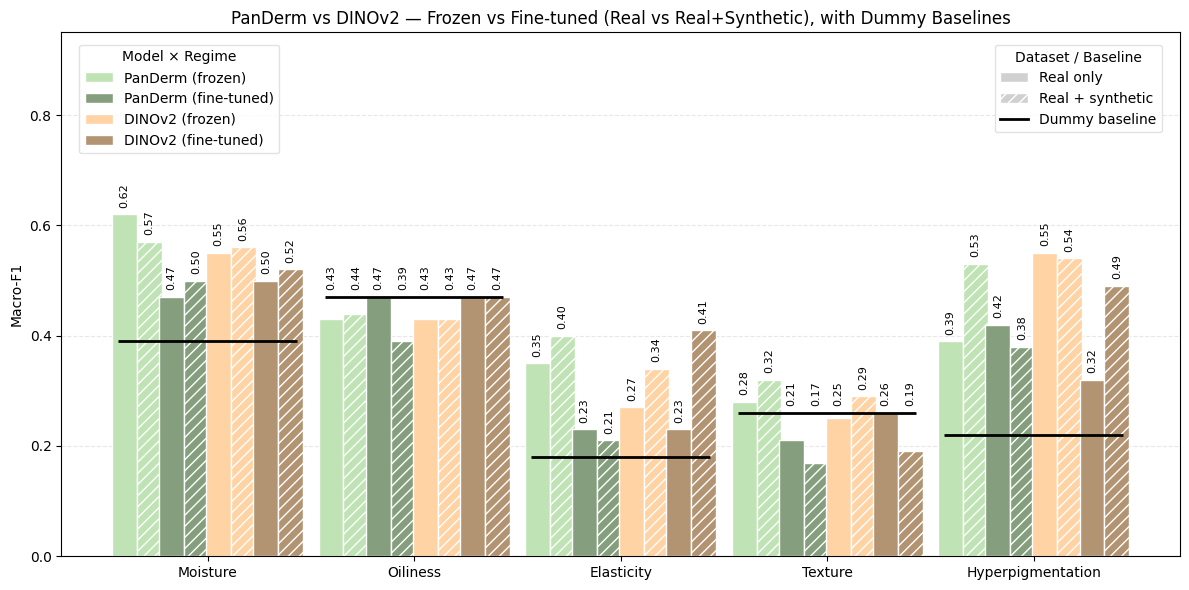

In [ ]:
# PanDerm & DINOv2 — Frozen vs Fine-tuned

# ===== Colors =====
FROZEN_PANDERM = "#BFE3B4"  # pastel green
FROZEN_DINOV2  = "#FFD3A4"  # pastel orange
def darken(hex_color, factor=0.70):
    h = hex_color.lstrip("#")
    r, g, b = [int(h[i:i+2], 16) for i in (0,2,4)]
    r = int(r*factor); g = int(g*factor); b = int(b*factor)
    return f"#{r:02X}{g:02X}{b:02X}"
FT_PANDERM = darken(FROZEN_PANDERM, 0.70)   # darker green
FT_DINOV2  = darken(FROZEN_DINOV2,  0.70)   # darker orange
EDGE_COLOR = "#FFFFFF"

# ===== Data =====
features = ["Moisture", "Oiliness", "Elasticity", "Texture", "Hyperpigmentation"]

# Frozen means
panderm_frozen = {
    "real":  [0.62, 0.43, 0.35, 0.28, 0.39],
    "synth": [0.57, 0.44, 0.40, 0.32, 0.53],
}
dinov2_frozen = {
    "real":  [0.55, 0.43, 0.27, 0.25, 0.55],
    "synth": [0.56, 0.43, 0.34, 0.29, 0.54],
}


panderm_ft = {
    "real":  [0.47, 0.47, 0.23, 0.21, 0.42],
    "synth": [0.50, 0.39, 0.21, 0.17, 0.38],
}



dinov2_ft = {
    "real":  [0.50, 0.47, 0.23, 0.26, 0.32],
    "synth": [0.52, 0.47, 0.41, 0.19, 0.49],
}

# Dummy baselines
dummy_macro_f1 = {
    "Moisture": 0.39, "Oiliness": 0.47, "Elasticity": 0.18,
    "Texture": 0.26, "Hyperpigmentation": 0.22
}


# ===== Layout =====
x = np.arange(len(features))
bar_w = 0.12
gap   = bar_w * 1.9

submodels = [
    ("PanDerm (frozen)",  panderm_frozen, FROZEN_PANDERM, 0),
    ("PanDerm (fine-tuned)", panderm_ft,   FT_PANDERM,    1),
    ("DINOv2 (frozen)",   dinov2_frozen,  FROZEN_DINOV2,  2),
    ("DINOv2 (fine-tuned)", dinov2_ft,     FT_DINOV2,     3),
]
offsets = (np.arange(len(submodels)) - 1.5) * gap

fig, ax = plt.subplots(figsize=(12, 6))
PAD_ABOVE = 0.012

for name, vals, color, k in submodels:
    pos_center = x + offsets[k]
    pos_real   = pos_center - bar_w/2
    pos_synth  = pos_center + bar_w/2

    # Bars
    ax.bar(pos_real,  vals["real"],  width=bar_w, color=color,
           edgecolor=EDGE_COLOR, linewidth=1.0, zorder=2)
    ax.bar(pos_synth, vals["synth"], width=bar_w, color=color,
           edgecolor=EDGE_COLOR, linewidth=1.0, hatch="///", zorder=2)

    # Value labels
    for j, (xx, v) in enumerate(zip(pos_real, vals["real"])):
        ax.text(xx, max(v, dummy_macro_f1[features[j]]) + PAD_ABOVE,
                f"{v:.2f}", ha="center", va="bottom", fontsize=8, rotation=90, zorder=6)
    for j, (xx, v) in enumerate(zip(pos_synth, vals["synth"])):
        ax.text(xx, max(v, dummy_macro_f1[features[j]]) + PAD_ABOVE,
                f"{v:.2f}", ha="center", va="bottom", fontsize=8, rotation=90, zorder=6)

# Dummy baselines
for j, feat in enumerate(features):
    y0 = dummy_macro_f1[feat]

    xmin = (x[j] + offsets[0]) - bar_w*0.75
    xmax = (x[j] + offsets[-1]) + bar_w*0.75
    ax.hlines(y0, xmin, xmax, color="black", linewidth=2.0, zorder=10)

# Axes & grid
ax.set_xticks(x)
ax.set_xticklabels(features)
ax.set_ylabel("Macro-F1")
ax.set_title("PanDerm vs DINOv2 — Frozen vs Fine-tuned (Real vs Real+Synthetic), with Dummy Baselines")
ax.set_ylim(0, 0.95)
ax.grid(axis="y", linestyle="--", alpha=0.3)

# Legends
model_handles = [
    Patch(facecolor=FROZEN_PANDERM, edgecolor=EDGE_COLOR, label="PanDerm (frozen)"),
    Patch(facecolor=FT_PANDERM,     edgecolor=EDGE_COLOR, label="PanDerm (fine-tuned)"),
    Patch(facecolor=FROZEN_DINOV2,  edgecolor=EDGE_COLOR, label="DINOv2 (frozen)"),
    Patch(facecolor=FT_DINOV2,      edgecolor=EDGE_COLOR, label="DINOv2 (fine-tuned)"),
]
dataset_handles = [
    Patch(facecolor="#D0D0D0", edgecolor=EDGE_COLOR, label="Real only"),
    Patch(facecolor="#D0D0D0", edgecolor=EDGE_COLOR, hatch="///", label="Real + synthetic"),
]
dummy_handle = Line2D([0], [0], color="black", lw=2, label="Dummy baseline")

leg1 = ax.legend(handles=model_handles, title="Model × Regime",
                 loc="upper left", bbox_to_anchor=(0.01, 0.99),
                 frameon=True, fancybox=True, framealpha=0.85, edgecolor="#DDDDDD")
ax.add_artist(leg1)
ax.legend(handles=dataset_handles + [dummy_handle], title="Dataset / Baseline",
          loc="upper right", bbox_to_anchor=(0.99, 0.99),
          frameon=True, fancybox=True, framealpha=0.85, edgecolor="#DDDDDD")

plt.tight_layout()

# Save
SAVE_DIR = "/content/drive/MyDrive/Skin_project/report_images"
os.makedirs(SAVE_DIR, exist_ok=True)
OUT_PATH = os.path.join(SAVE_DIR, "macroF1_panDerm_dino_frozen_vs_ft_side_by_side.png")
fig.savefig(OUT_PATH, dpi=300, bbox_inches="tight")
print(f"Saved figure to: {OUT_PATH}")

plt.show()
